# Statystyczna Analiza Danych - projekt

### Cel: Zbadanie, które czynniki chemiczne mają największy wpływ na ocenę jakości wina

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

Ogarniecie zbioru danych

In [44]:
df = pd.read_csv("data/WineQT.csv")
df.columns = ["Kwasowość nielotna","Kwasowość lotna","Kwas cytrynowy","Cukier resztkowy","Chlorki","Wolny dwutlenek siarki","Całkowity dwutlenek siarki","Gęstość","pH","Siarczany","Zawartość alkoholu","Ocena","ID"]
df.drop('ID',axis=1,inplace=True)
df

,Kwasowość nielotna,Kwasowość lotna,Kwas cytrynowy,Cukier resztkowy,Chlorki,Wolny dwutlenek siarki,Całkowity dwutlenek siarki,Gęstość,pH,Siarczany,Zawartość alkoholu,Ocena
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6


podstawowe parametry statystyczne zmiennych numerycznych

In [45]:
parametryStatystyczne = df.describe().loc[['mean','std','min','max']].T
parametryStatystyczne

,mean,std,min,max
Kwasowość nielotna,8.311111,1.747595,4.60000,15.90000
Kwasowość lotna,0.531339,0.179633,0.12000,1.58000
Kwas cytrynowy,0.268364,0.196686,0.00000,1.00000
Cukier resztkowy,2.532152,1.355917,0.90000,15.50000
Chlorki,0.086933,0.047267,0.01200,0.61100
Wolny dwutlenek siarki,15.615486,10.250486,1.00000,68.00000
Całkowity dwutlenek siarki,45.914698,32.782130,6.00000,289.00000
Gęstość,0.996730,0.001925,0.99007,1.00369
pH,3.311015,0.156664,2.74000,4.01000
Siarczany,0.657708,0.170399,0.33000,2.00000


macierz korelacji z oceną końcową

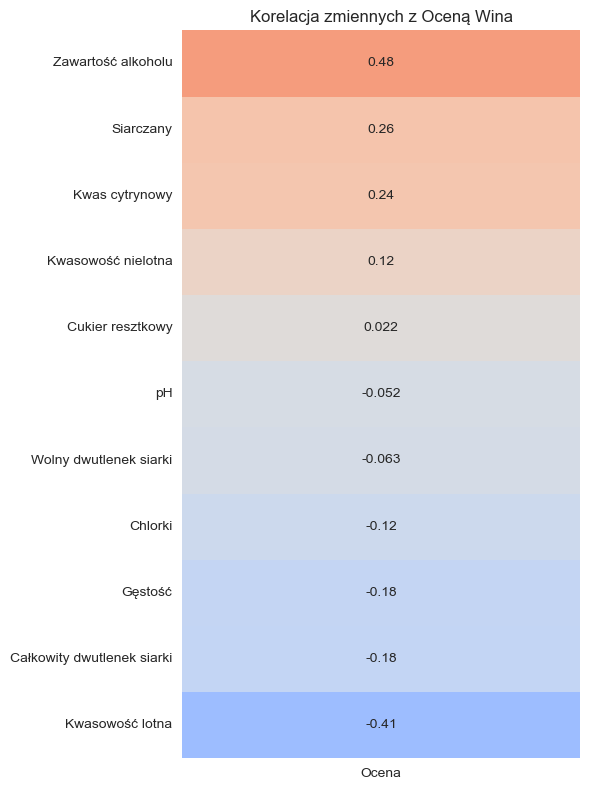

In [46]:
korelacja_z_celem = df.corr()[['Ocena']].sort_values(by='Ocena', ascending=False)
korelacja_z_celem = korelacja_z_celem.drop('Ocena')

plt.figure(figsize=(6, 8))
sns.heatmap(korelacja_z_celem,
            annot=True,
            cmap='coolwarm',
            vmin=-1, vmax=1,
            cbar=False)
plt.title("Korelacja zmiennych z Oceną Wina")
plt.tight_layout()
plt.savefig("korelacja_z_celem.png")

wnioski: Im wyższy alkohol, tym wyższa ocena. Im wyższa kwasowość lotna, tym ocena jest niższa. pH i cukier resztkowy mają znikomy wpływ na oceny końcowe

##### Klasyfikacja wina

In [47]:
df['Klasa'] = np.where(df['Ocena']>5,1,0)

### Test t-studenta
pytanie badawcze: czy wina DOBRE mają średnio większą zawartość alkoholu od win SŁABYCH

Hipoteza H0: Średnia zawartość alkoholu w obu grupach jest taka sama

Hipoteza H1: Średnia zawartość alkoholu w winach dobrych jest wyższa

In [48]:
# Podział kolumny z alkoholem według klasy wina
zmienna_badana = 'Zawartość alkoholu'
grupa_slaba = df[df['Klasa'] == 0][zmienna_badana]
grupa_dobra = df[df['Klasa'] == 1][zmienna_badana]
print(f"Liczność obu grup:\nWina słabe: {len(grupa_slaba)}\nWina dobre: {len(grupa_dobra)}")

# Średnie wartości dla obu grup
print(f"\nŚrednia (Słabe wina): {grupa_slaba.mean():.4f}")
print(f"Średnia (Dobre wina): {grupa_dobra.mean():.4f}")

# Normalność
shapiro_slaba = stats.shapiro(grupa_slaba)
shapiro_dobra = stats.shapiro(grupa_dobra)

print(f"Test Shapiro-Wilka (Słabe wina): p-value = {shapiro_slaba.pvalue}")
print(f"Test Shapiro-Wilka (Dobre wina): p-value = {shapiro_dobra.pvalue}")
if shapiro_slaba.pvalue < 0.05 or shapiro_dobra.pvalue < 0.05:
    print("-> Wniosek: Rozkłady nie są normalne (ale ze względu na N > 30 stosujemy test t na podst. Centralnego Twierdzenia Granicznego).")
else:
    print("-> Wniosek: Rozkłady są normalne.")

# B. Jednorodność wariancji (Test Levene'a)
# To decyduje, czy użyjemy klasycznego testu t, czy testu Welcha (z poprawką na wariancję).
levene_test = stats.levene(grupa_slaba, grupa_dobra)
print(f"Test Levene'a: p-value = {levene_test.pvalue}")

rowne_wariancje = True
if levene_test.pvalue < 0.05:
    print("-> Wniosek: Wariancje SĄ RÓŻNE (użyjemy parametru equal_var=False).")
    rowne_wariancje = False
else:
    print("-> Wniosek: Wariancje są jednorodne.")

# 3. WYKONANIE TESTU T-STUDENTA
print("\n[2.1.3 Wykonanie Testu t-Studenta]")

# alternative='less' oznacza H1: średnia grupy pierwszej (słabe) jest MNIEJSZA niż drugiej (dobre)
t_stat, p_val = stats.ttest_ind(grupa_slaba, grupa_dobra, equal_var=rowne_wariancje, alternative='less')

print(f"Statystyka t: {t_stat:.4f}")
print(f"P-value: {p_val:.20f}") # Duża precyzja, bo wynik może być bliski zeru

# 4. INTERPRETACJA WYNIKU
alpha = 0.05
print("\n--- DECYZJA ---")
if p_val < alpha:
    print("ODRZUCAMY H0. Wynik jest istotny statystycznie.")
    print(f"Wniosek: Wina 'Dobre' mają ISTOTNIE WYŻSZĄ średnią '{zmienna_badana}' niż wina 'Słabe'.")
else:
    print("BRAK PODSTAW do odrzucenia H0.")
    print("Wniosek: Nie ma istotnej różnicy między grupami.")

Liczność obu grup:
Wina słabe: 522
Wina dobre: 621

Średnia (Słabe wina): 9.9225
Średnia (Dobre wina): 10.8789
Test Shapiro-Wilka (Słabe wina): p-value = 9.146591401883862e-22
Test Shapiro-Wilka (Dobre wina): p-value = 3.5857069575319164e-08
-> Wniosek: Rozkłady nie są normalne (ale ze względu na N > 30 stosujemy test t na podst. Centralnego Twierdzenia Granicznego).
Test Levene'a: p-value = 3.157631979224916e-22
-> Wniosek: Wariancje SĄ RÓŻNE (użyjemy parametru equal_var=False).

[2.1.3 Wykonanie Testu t-Studenta]
Statystyka t: -17.0671
P-value: 0.00000000000000000000

--- DECYZJA ---
ODRZUCAMY H0. Wynik jest istotny statystycznie.
Wniosek: Wina 'Dobre' mają ISTOTNIE WYŻSZĄ średnią 'Zawartość alkoholu' niż wina 'Słabe'.


### ANOVA
##### H0: Średnie stężenie siarczanów jest równe we wszystkich grupach jakościowych.
##### H1: Przynajmniej jedna średnia różni się od pozostałych.


In [49]:
def kategoryzuj_jakosc(score):
    if score <= 4:
        return 'Niska (3-4)'
    elif score <= 6:
        return 'Średnia (5-6)'
    else:
        return 'Wysoka (7-8)'

# Klasyfikacja na grupy bazując na ocenach oraz utworzenie podzielonych zbiorów obecności siarczanów
df['Grupa_Jakości'] = df['Ocena'].apply(kategoryzuj_jakosc)
zmienna_anova = 'Siarczany'

grupa_niska = df[df['Grupa_Jakości'] == 'Niska (3-4)'][zmienna_anova]
grupa_srednia = df[df['Grupa_Jakości'] == 'Średnia (5-6)'][zmienna_anova]
grupa_wysoka = df[df['Grupa_Jakości'] == 'Wysoka (7-8)'][zmienna_anova]

print(f"Liczebności grup: \n{df['Grupa_Jakości'].value_counts()}")

# === KROK 2: Sprawdzenie założeń (2.2.2) ===
print("\n--- 2.2.2 Wymagania testu ---")
# Normalność (Shapiro) - formalność, bo przy N>30 działa CTG
print(f"Shapiro (Niska): p={stats.shapiro(grupa_niska).pvalue}")
print(f"Shapiro (Średnia): p={stats.shapiro(grupa_srednia).pvalue}")
print(f"Shapiro (Wysoka): p={stats.shapiro(grupa_wysoka).pvalue}")

# Jednorodność wariancji (Levene)
stat_lev, p_lev = stats.levene(grupa_niska, grupa_srednia, grupa_wysoka)
print(f"Test Levene'a: p={p_lev}")
if p_lev < 0.05:
    print("Uwaga: Wariancje nie są równe.")

# === KROK 3: Wykonanie ANOVA (2.2.3) ===
print("\n--- 2.2.3 Wykonanie ANOVA ---")
f_stat, p_val = stats.f_oneway(grupa_niska, grupa_srednia, grupa_wysoka)

print(f"Statystyka F: {f_stat}")
print(f"P-value: {p_val:}")

if p_val < 0.05:
    print("\nWNIOSEK: Odrzucamy H0. Istnieją istotne różnice między grupami.")
    print("Przeprowadzamy test post-hoc Tukeya, aby sprawdzić, które grupy się różnią.")
    tukey = pairwise_tukeyhsd(endog=df[zmienna_anova], groups=df['Grupa_Jakości'], alpha=0.05)
    print(tukey)
else:
    print("\nWNIOSEK: Brak podstaw do odrzucenia H0. Średnie są równe.")

Liczebności grup: 
Grupa_Jakości
Średnia (5-6)    945
Wysoka (7-8)     159
Niska (3-4)       39
Name: count, dtype: int64

--- 2.2.2 Wymagania testu ---
Shapiro (Niska): p=2.4675882704819255e-09
Shapiro (Średnia): p=8.348007175177117e-33
Shapiro (Wysoka): p=0.000663869754912304
Test Levene'a: p=0.6537348741694105

--- 2.2.3 Wykonanie ANOVA ---
Statystyka F: 26.059233510397068
P-value: 8.584170585713025e-12

WNIOSEK: Odrzucamy H0. Istnieją istotne różnice między grupami.
Przeprowadzamy test post-hoc Tukeya, aby sprawdzić, które grupy się różnią.
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1        group2    meandiff p-adj   lower  upper  reject
----------------------------------------------------------------
 Niska (3-4)  Wysoka (7-8)   0.1215 0.0001  0.0516 0.1914   True
 Niska (3-4) Średnia (5-6)   0.0199 0.7457 -0.0441 0.0838  False
Wysoka (7-8) Średnia (5-6)  -0.1016    0.0 -0.1351 -0.068   True
-----------------------------------------------------------

C:\Users\mateuszlamla\AppData\Local\Temp\ipykernel_20032\880765651.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Grupa_Jakości', y='Siarczany', data=df,


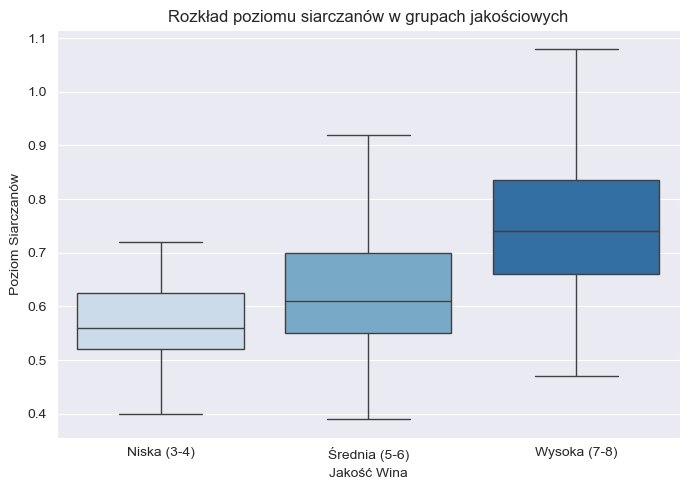

In [50]:
# Wykres do sekcji ANOVA: Siarczany w podziale na jakość
plt.figure(figsize=(7, 5))
# Ustawiamy kolejność, żeby na wykresie było logicznie: Niska -> Średnia -> Wysoka
order_list = ['Niska (3-4)', 'Średnia (5-6)', 'Wysoka (7-8)']
sns.boxplot(x='Grupa_Jakości', y='Siarczany', data=df,
            order=order_list, palette='Blues', showfliers=False)
plt.title("Rozkład poziomu siarczanów w grupach jakościowych")
plt.xlabel("Jakość Wina")
plt.ylabel("Poziom Siarczanów")
plt.tight_layout()
plt.savefig('anova_boxplot.png', dpi=300, bbox_inches='tight') # Zapisz plik
plt.show()

Wina wysokiej jakości (7-8) charakteryzują się istotnie wyższym poziomem siarczanów w porównaniu zarówno do win niskiej jakości ($p < 0.001$), jak i średniej jakości ($p < 0.001$).Nie odnotowano natomiast istotnych różnic w poziomie siarczanów między winami niskiej i średniej jakości ($p = 0.746$).

### TESTY NIEPARAMETRYCZNE

##### Test Manna-Whitneya

##### H0: Rozkłady poziomu chlorków w grupie win słabych i win dobrych są identyczne
##### H1: Rozkłady poziomu chlorków w obu grupach różnią się istotnie

In [51]:
print("=== 3. TESTY NIEPARAMETRYCZNE ===")

# --- 3.1 Test Manna-Whitneya (Wilcoxona dla sumy rang) ---
zmienna_mw = 'Chlorki'
grupa_0 = df[df['Klasa'] == 0][zmienna_mw]
grupa_1 = df[df['Klasa'] == 1][zmienna_mw]

print(f"\n[3.1] Test Manna-Whitneya dla zmiennej: {zmienna_mw}")
# Sprawdzamy normalność, żeby uzasadnić wybór testu
print(f"Shapiro (Słabe): p={stats.shapiro(grupa_0).pvalue}") # Prawdopodobnie < 0.05
print(f"Shapiro (Dobre): p={stats.shapiro(grupa_1).pvalue}")

u_stat, p_val_mw = stats.mannwhitneyu(grupa_0, grupa_1, alternative='two-sided')
print(f"Wynik U-testu: p-value = {p_val_mw:.20f}")

if p_val_mw < 0.05:
    print("-> Różnica istotna statystycznie.")
else:
    print("-> Brak różnic.")

=== 3. TESTY NIEPARAMETRYCZNE ===

[3.1] Test Manna-Whitneya dla zmiennej: Chlorki
Shapiro (Słabe): p=6.896567863757919e-38
Shapiro (Dobre): p=9.568726388061735e-37
Wynik U-testu: p-value = 0.00000000525019308113
-> Różnica istotna statystycznie.


Odrzucone h0

##### Test Kruskala-Wallisa

##### H0: Mediany (rozkłady) kwasowości lotnej są równe we wszystkich analizowanych grupach jakościowych.
##### H1: Przynajmniej jedna z grup różni się istotnie poziomem (medianą) kwasowości lotnej od pozostałych.

In [52]:
zmienna_kw = 'Kwasowość lotna'
grupa_niska_kw = df[df['Grupa_Jakości'] == 'Niska (3-4)'][zmienna_kw]
grupa_srednia_kw = df[df['Grupa_Jakości'] == 'Średnia (5-6)'][zmienna_kw]
grupa_wysoka_kw = df[df['Grupa_Jakości'] == 'Wysoka (7-8)'][zmienna_kw]

print(f"\n[3.2] Test Kruskala-Wallisa dla zmiennej: {zmienna_kw}")
# Sprawdzamy normalność
print(f"Shapiro (Niska): p={stats.shapiro(grupa_niska_kw).pvalue}")
print(f"Shapiro (Średnia): p={stats.shapiro(grupa_srednia_kw).pvalue}")
print(f"Shapiro (Wysoka): p={stats.shapiro(grupa_wysoka_kw).pvalue}")

h_stat, p_val_kw = stats.kruskal(grupa_niska, grupa_srednia, grupa_wysoka)
print(f"Statystyka H: {h_stat}")
print(f"Wynik K-W: p-value = {p_val_kw}")

if p_val_kw < 0.05:
    print("-> Istnieją istotne różnice między co najmniej dwiema grupami.")
    # Sprawdzenie median, żeby wiedzieć kto jest lepszy
    print("Mediany w grupach:")
    print(df.groupby('Grupa_Jakości')[zmienna_kw].median())


[3.2] Test Kruskala-Wallisa dla zmiennej: Kwasowość lotna
Shapiro (Niska): p=0.031058649818927364
Shapiro (Średnia): p=1.3253481909369188e-08
Shapiro (Wysoka): p=1.2040118361200485e-06
Statystyka H: 102.54864635741488
Wynik K-W: p-value = 5.393173354302315e-23
-> Istnieją istotne różnice między co najmniej dwiema grupami.
Mediany w grupach:
Grupa_Jakości
Niska (3-4)      0.68
Wysoka (7-8)     0.36
Średnia (5-6)    0.54
Name: Kwasowość lotna, dtype: float64


ODRZUCONE h0

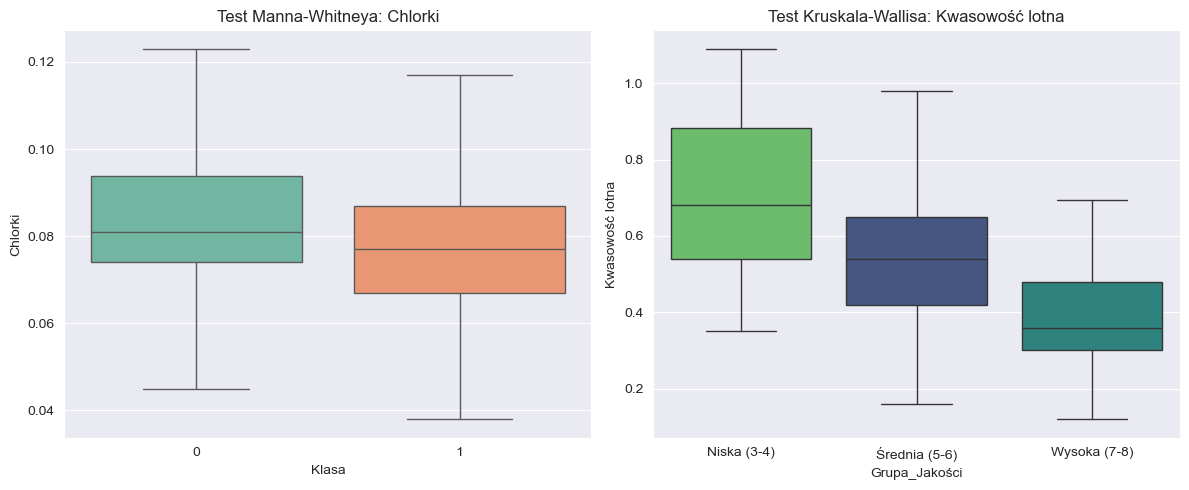

In [53]:
# --- Wizualizacja ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Wykres dla 3.1
sns.boxplot(ax=axes[0], x='Klasa', y=zmienna_mw, data=df, showfliers=False, palette='Set2', hue = 'Klasa',legend=False)
axes[0].set_title(f'Test Manna-Whitneya: {zmienna_mw}')

# Wykres dla 3.2
sns.boxplot(ax=axes[1], x='Grupa_Jakości', y=zmienna_kw, data=df,
            order=['Niska (3-4)', 'Średnia (5-6)', 'Wysoka (7-8)'], showfliers=False, palette='viridis',hue='Grupa_Jakości', legend=False)
axes[1].set_title(f'Test Kruskala-Wallisa: {zmienna_kw}')

plt.tight_layout()
plt.savefig("testy_nieparametryczne.png")
plt.show()

### REGRESJA LINIOWA

In [54]:
Y = df['Ocena']
X = df[['Zawartość alkoholu', 'Siarczany', 'Kwasowość lotna']]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Ocena   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     206.7
Date:                Tue, 13 Jan 2026   Prob (F-statistic):          4.96e-107
Time:                        18:15:37   Log-Likelihood:                -1126.2
No. Observations:                1143   AIC:                             2260.
Df Residuals:                    1139   BIC:                             2280.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.6826      0

In [55]:
predictions = model.predict(X)

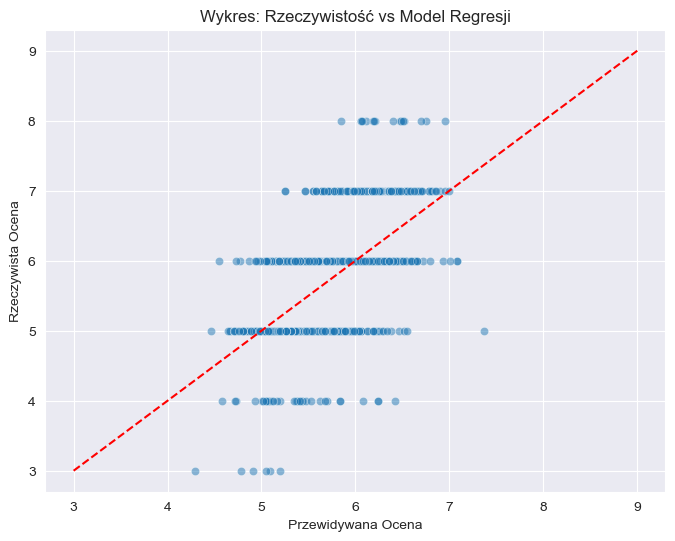

In [56]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions, y=Y, alpha=0.5)
plt.plot([3, 9], [3, 9], color='red', linestyle='--')
plt.xlabel("Przewidywana Ocena")
plt.ylabel("Rzeczywista Ocena")
plt.title("Wykres: Rzeczywistość vs Model Regresji")
plt.savefig("regresja.png")
plt.show()

### Finalny model matematyczny bazując na współczynnikach z regresji wielorakiej
#### Ocena = 2.68 + 0.31 * Alkohol + 0.66 * Siarczany - 1.28 * KwasowośćLotna

#### R^2 = 0.353